# Diabetes Prediction & Analysis using Machine Learning

This project demonstrates the use of various machine learning models to predict diabetes based on patient health features. It includes:

- Exploratory Data Analysis (EDA)
- Correlation heatmaps and distributions
- Model training using Decision Tree, Naive Bayes, and Ensemble (VotingClassifier)
- Parametric validation
- Hierarchical clustering for pattern discovery

**Dataset Used**: `LTC_selected_features.csv` with multiple biomarkers for Type-2 diabetes detection.


In [1]:
# Install necessary libraries
!pip install seaborn --quiet

# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


## Load and Prepare the Dataset

We load the dataset, drop unnecessary columns, and map numeric labels to human-readable class names for better interpretation.


In [2]:
# Upload CSV file
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('LTC_selected_features.csv')
df.drop('SampleID', axis=1, inplace=True)

# Map labels to categories
df['Diabetes_Category'] = df['Class'].map({1: 'Diabetes', 0: 'No Diabetes'})
feature_columns = df.columns[:-2]

# Fill missing values if any
df[feature_columns] = df[feature_columns].fillna(df[feature_columns].mean())

# Preview
df.head()


Saving LTC_selected_features.csv to LTC_selected_features.csv


,Peptide_27,Fasting_plasma_glucose_(mmol/l),HbA1c,Fasting_plasma_insulin_(pmol/l),C-Peptide_(nmol/l),HOMA-IR,Free_fatty_acids_(mmol/l),Class,Diabetes_Category
0,10.42,4.73,6.5,121.4,1.63,3.7,1.03,1,Diabetes
1,102.86,7.16,7.6,226.0,1.11,10.4,0.98,1,Diabetes
2,9.84,5.06,4.9,39.7,0.75,1.3,0.35,0,No Diabetes
3,41.03,5.35,6.3,203.3,2.02,7.0,1.17,1,Diabetes
4,12.30,5.37,5.6,50.8,1.19,1.7,0.32,0,No Diabetes


## Correlation Heatmap

We analyze feature correlation to understand multicollinearity and influence between attributes.


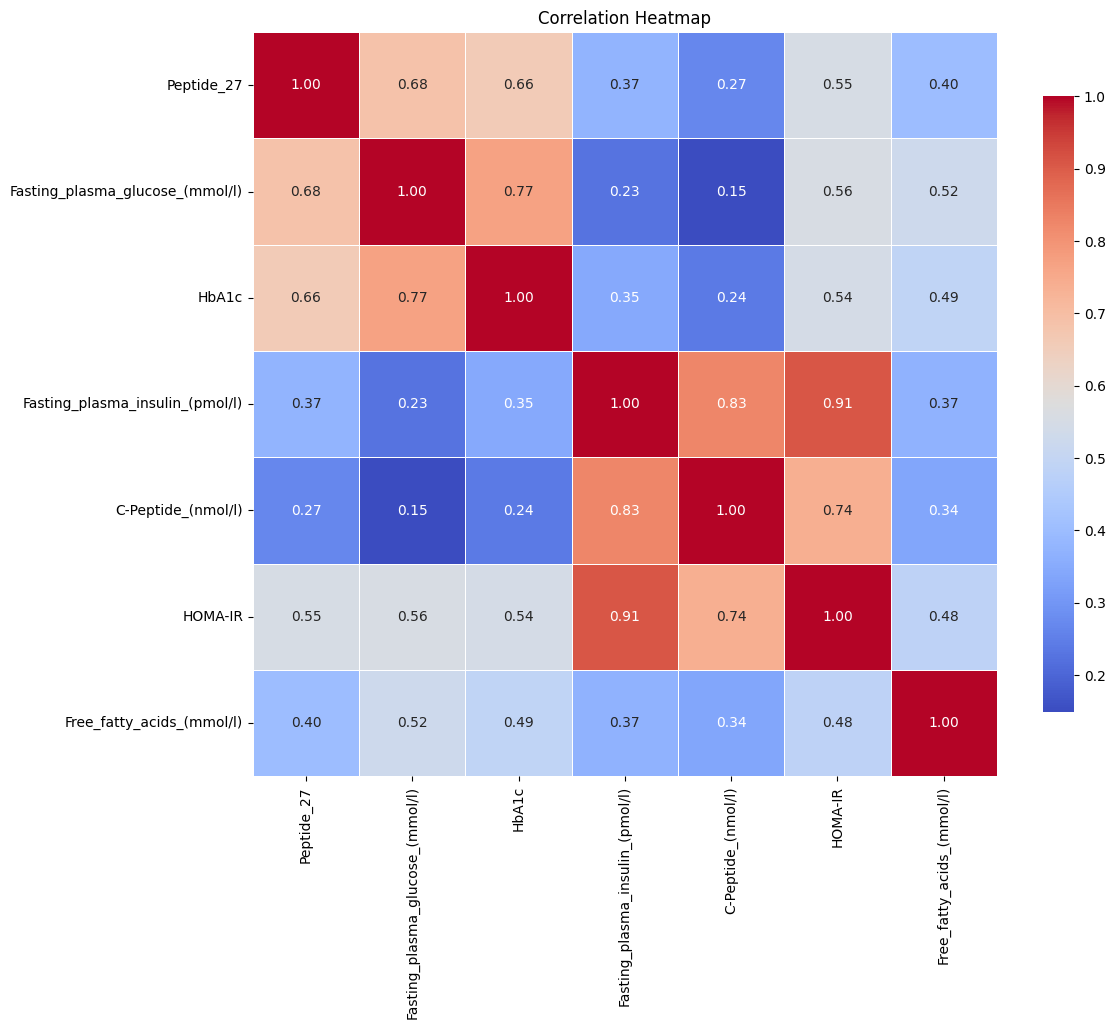

In [3]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[feature_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()


## Feature Distribution by Class

Here we visualize normalized distributions of each feature, separated by diabetes class.


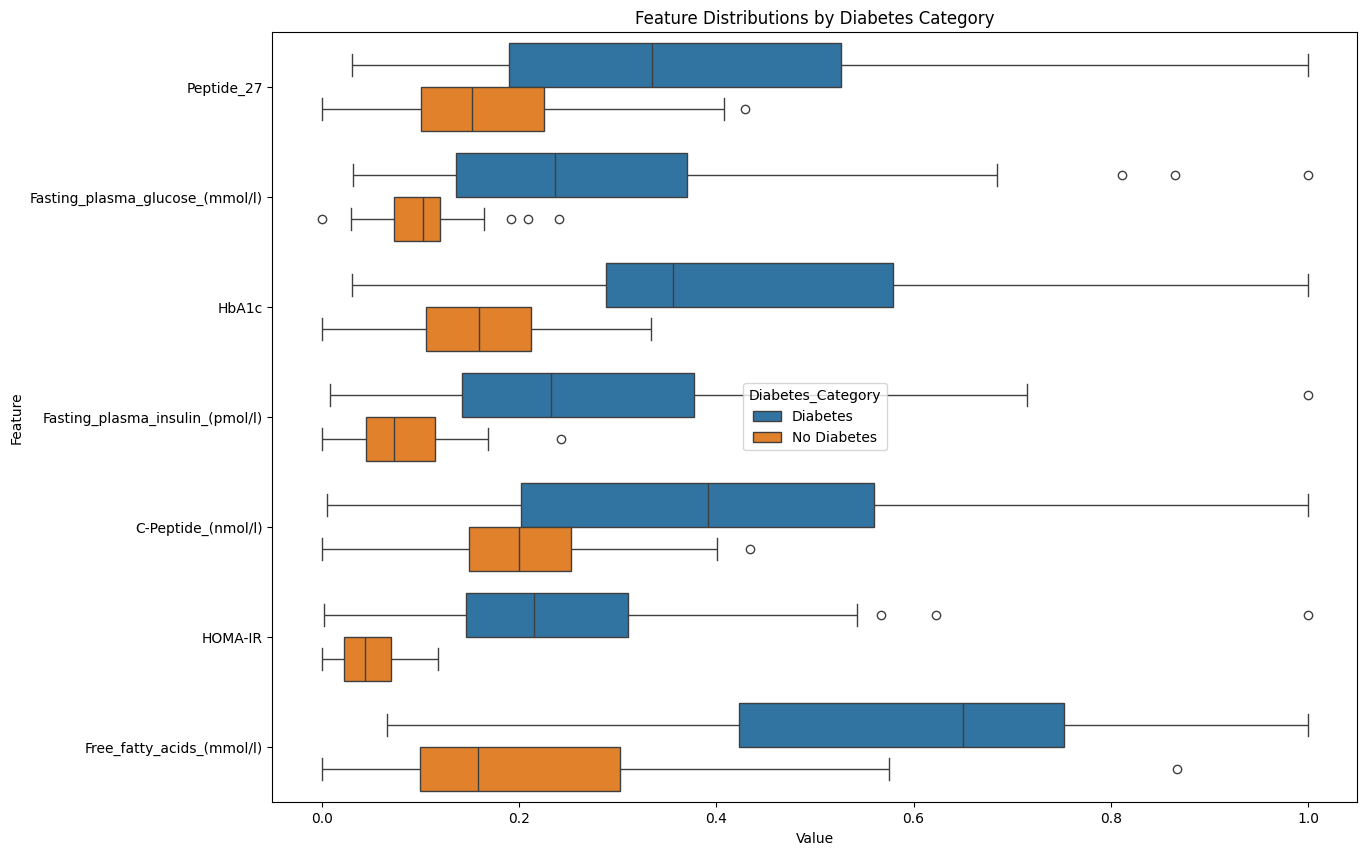

In [4]:
df_norm = df.copy()
df_norm[feature_columns] = df_norm[feature_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
melted_df = pd.melt(df_norm, id_vars=['Diabetes_Category', 'Class'], value_vars=feature_columns,
                    var_name='Feature', value_name='Value')
plt.figure(figsize=(14, 10))
sns.boxplot(y='Feature', x='Value', hue='Diabetes_Category', data=melted_df)
plt.title('Feature Distributions by Diabetes Category')
plt.show()


**Creating a Sample for parametric validation**

It will be used by all the models below to predict if the sample is Diabetic or Non-Diabetic

In [19]:
# Define the two raw sample inputs
sample_values_1 = [
    61.47,   # peptide_27
    4.87,    # Fasting_plasma_glucose_(mmol/l)
    5.8,     # HbA1c
    479.9,   # Fasting_plasma_insulin_(pmol/l)
    2.86,    # C-Peptide_(nmol/l)
    15,      # HOMA-IR
    0.75     # Free_fatty_acids_(mmol/l)
]

sample_values_2 = [
    13.86,
    5.27,
    4.8,
    45.6,
    0.85,
    1.5,
    0.34
]

# Prepare original dataset
X = df.drop(['Class', 'Diabetes_Category'], axis=1)
y = df['Class']

# Fit MinMaxScaler on the entire X (you can also use only training data to be exact)
scaler = MinMaxScaler()
scaler.fit(X)

# Normalize the samples
normalized_sample_1 = scaler.transform([sample_values_1])
normalized_sample_2 = scaler.transform([sample_values_2])

print("Normalized Sample 1:\n", normalized_sample_1)
print("\nNormalized Sample 2:\n", normalized_sample_2)


Normalized Sample 1:
 [[0.52545097 0.07161981 0.22727273 0.60533854 0.65891473 0.32366071
  0.5       ]]

Normalized Sample 2:
 [[0.10028577 0.09839357 0.07575758 0.03984375 0.13953488 0.02232143
  0.15833333]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Decision Tree Classifier

We train a Decision Tree to classify diabetic and non-diabetic patients.


In [20]:
X = df.drop(['Class', 'Diabetes_Category'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred) * 100, '%')
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Parametric Test
prediction = clf.predict(normalized_sample_1)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)

prediction = clf.predict(normalized_sample_2)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)


Decision Tree Accuracy: 85.0 %
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.77      0.87        13

    accuracy                           0.85        20
   macro avg       0.85      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20

Confusion Matrix:
 [[ 7  0]
 [ 3 10]]
Prediction for Fixed Sample: Diabetic
Prediction for Fixed Sample: Non-Diabetic


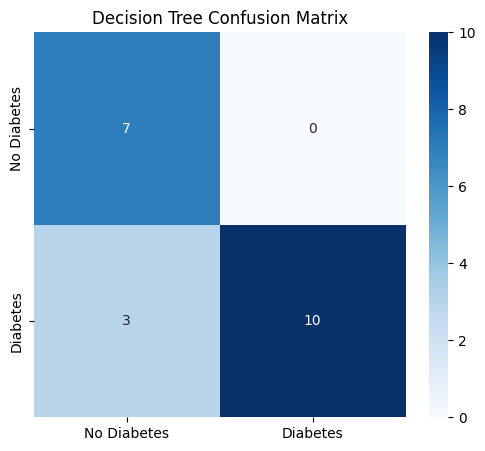

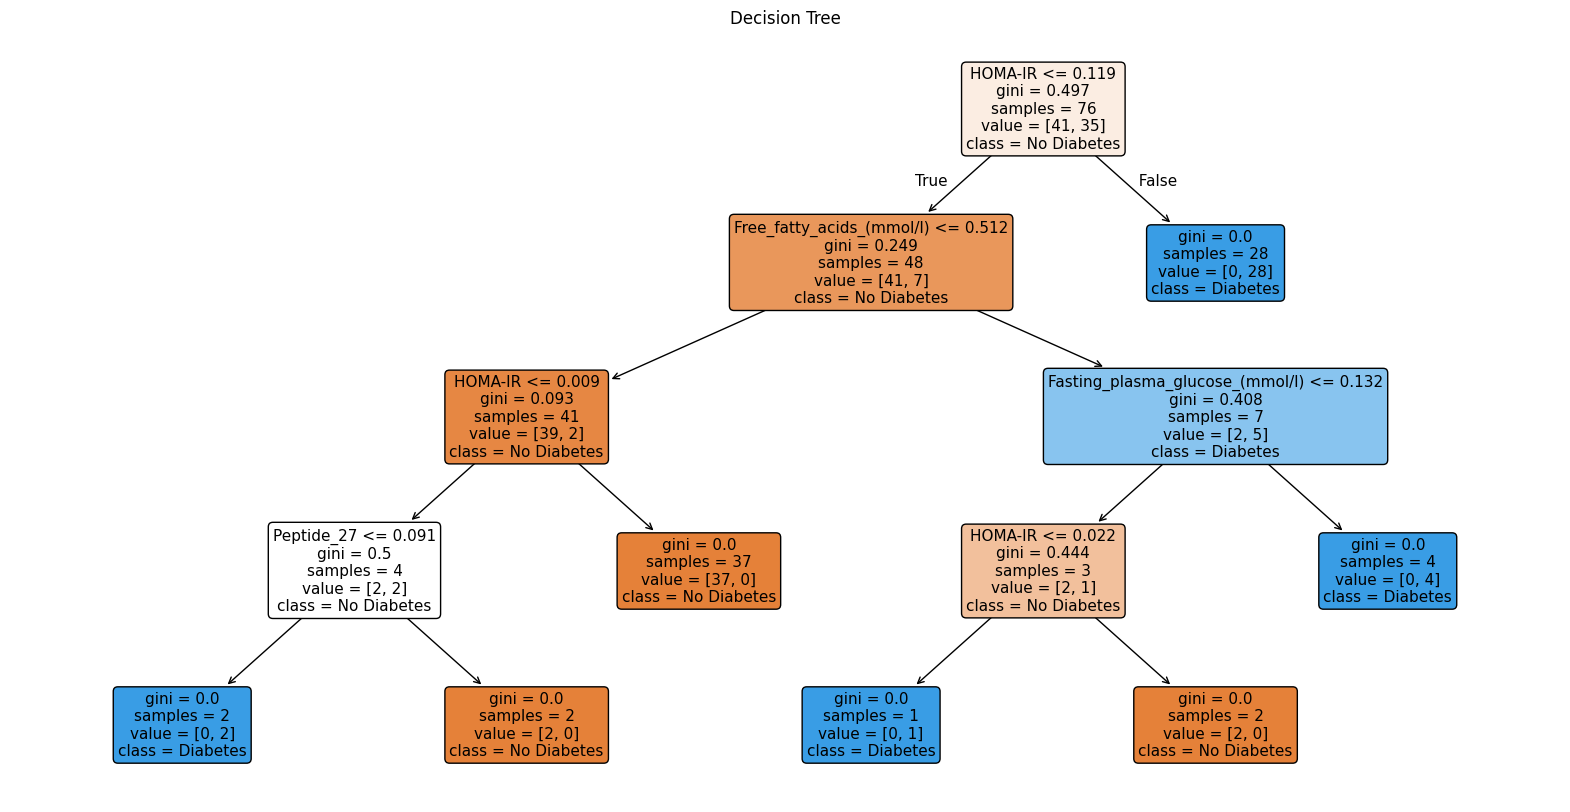

Tree Structure:
 |--- HOMA-IR <= 0.12
|   |--- Free_fatty_acids_(mmol/l) <= 0.51
|   |   |--- HOMA-IR <= 0.01
|   |   |   |--- Peptide_27 <= 0.09
|   |   |   |   |--- class: 1
|   |   |   |--- Peptide_27 >  0.09
|   |   |   |   |--- class: 0
|   |   |--- HOMA-IR >  0.01
|   |   |   |--- class: 0
|   |--- Free_fatty_acids_(mmol/l) >  0.51
|   |   |--- Fasting_plasma_glucose_(mmol/l) <= 0.13
|   |   |   |--- HOMA-IR <= 0.02
|   |   |   |   |--- class: 1
|   |   |   |--- HOMA-IR >  0.02
|   |   |   |   |--- class: 0
|   |   |--- Fasting_plasma_glucose_(mmol/l) >  0.13
|   |   |   |--- class: 1
|--- HOMA-IR >  0.12
|   |--- class: 1



In [6]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Decision Tree Confusion Matrix')
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], rounded=True)
plt.title('Decision Tree')
plt.show()

print("Tree Structure:\n", export_text(clf, feature_names=list(X.columns)))


## Ensemble Classifier (Voting)

Combining Logistic Regression, Decision Tree, and SVM in a hard voting scheme.


In [23]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

ensemble_clf = VotingClassifier(estimators=[('log', log_clf), ('tree', tree_clf), ('svm', svm_clf)], voting='hard')
ensemble_clf.fit(X_train, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test)

print("Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble)*100,'%')
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

# Parametric Test
prediction = ensemble_clf.predict(normalized_sample_1)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)

prediction = ensemble_clf.predict(normalized_sample_2)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)


Voting Ensemble Accuracy: 90.0 %
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.85      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
 [[ 7  0]
 [ 2 11]]
Prediction for Fixed Sample: Diabetic
Prediction for Fixed Sample: Non-Diabetic


## Naive Bayes Classifier

We apply Gaussian Naive Bayes to the diabetes dataset.


Naive Bayes Accuracy: 90.0 %
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.85      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
 [[ 7  0]
 [ 2 11]]


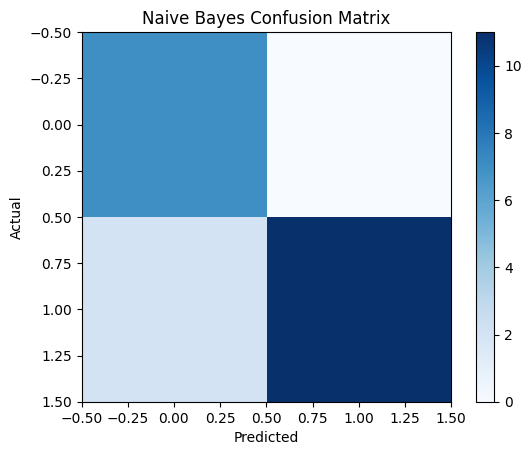

Prediction for Fixed Sample: Diabetic
Prediction for Fixed Sample: Non-Diabetic


In [24]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb)*100,'%')
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

# Confusion Matrix
plt.imshow(confusion_matrix(y_test, y_pred_nb), interpolation='nearest', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Parametric Test
prediction = gnb.predict(normalized_sample_1)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)

prediction = gnb.predict(normalized_sample_2)[0]
prediction_label = "Diabetic" if prediction == 1 else "Non-Diabetic"
print("Prediction for Fixed Sample:", prediction_label)

## Hierarchical Clustering

We use seaborn’s clustermap with Manhattan distance to visualize clustering of feature patterns.


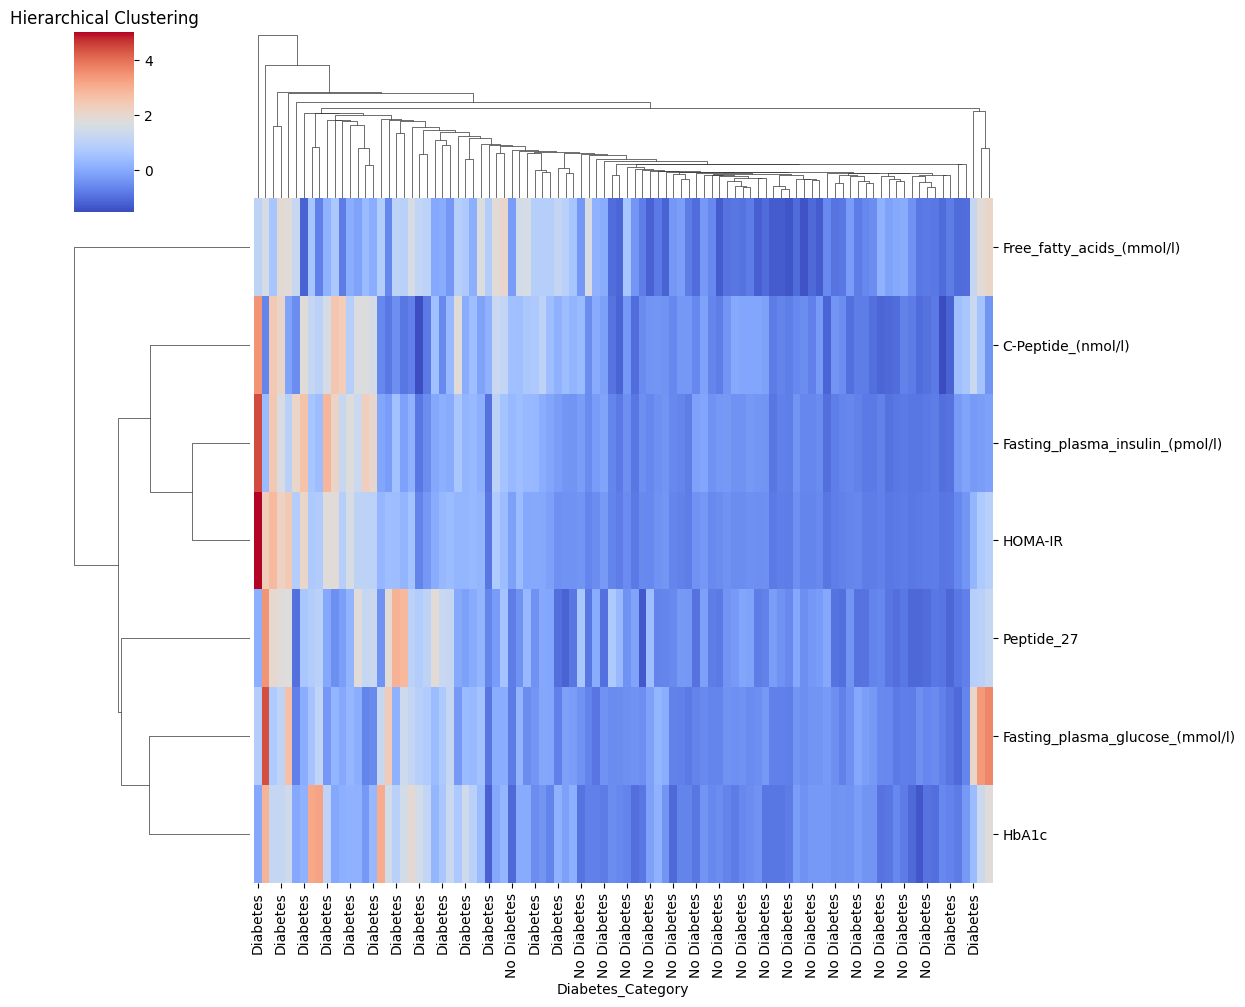

In [12]:
scaler_std = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_columns] = scaler_std.fit_transform(df_scaled[feature_columns])
df_transposed = df_scaled[feature_columns].T
df_transposed.columns = df['Diabetes_Category']

sns.clustermap(df_transposed, cmap='coolwarm', figsize=(12, 10), method='single', metric='cityblock', cbar_kws={"shrink": .8})
plt.title('Hierarchical Clustering')
plt.show()


**Bar Graph to Compare Model Performance**

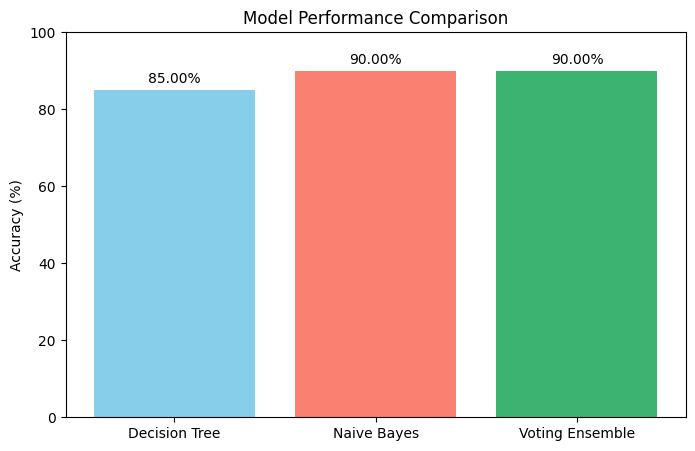

In [25]:
# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt_clf.predict(X_test))

# Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
acc_nb = accuracy_score(y_test, nb_clf.predict(X_test))

# Ensemble (Voting)
log_clf = LogisticRegression(random_state=42, max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
ensemble_clf = VotingClassifier(estimators=[
    ('log', log_clf), ('tree', tree_clf), ('svm', svm_clf)
], voting='hard')
ensemble_clf.fit(X_train, y_train)
acc_ensemble = accuracy_score(y_test, ensemble_clf.predict(X_test))

# Accuracy comparison
model_names = ['Decision Tree', 'Naive Bayes', 'Voting Ensemble']
accuracies = [acc_dt, acc_nb, acc_ensemble]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, [a * 100 for a in accuracies], color=['skyblue', 'salmon', 'mediumseagreen'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()
